Extensive EDA on Patient_id dataset

In [17]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from google.colab import drive

drive.mount('/content/drive')
%cd /content/drive/My Drive/SIADS_591/Oral_Exam

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/SIADS_591/Oral_Exam


Data Cleaning


In [18]:
# Read dataset
# converting all '', '-', 'nan', 'etc' to NA values by passing a na_values list comprehension
# filter for korea
# remove duplicated patient id record

Patient_df = pd.read_csv('PatientInfo.csv', na_values = ['','-',' ', 'nan', 'etc'])
Patient_df = Patient_df.loc[Patient_df['country'] == "Korea"]

# converting dates to correct date time format by passing pd.datetime function

Patient_df['symptom_onset_date'] = pd.to_datetime(Patient_df['symptom_onset_date'], format='%Y-%m-%d')
Patient_df['confirmed_date'] = pd.to_datetime(Patient_df['confirmed_date'], format='%Y-%m-%d')
Patient_df['released_date'] = pd.to_datetime(Patient_df['released_date'], format='%Y-%m-%d')
Patient_df['deceased_date'] = pd.to_datetime(Patient_df['deceased_date'], format='%Y-%m-%d')

Data challenges - 
1) alot of Null values for some columns


In [19]:
Patient_df.isnull().sum()

patient_id               0
sex                   1118
age                   1376
country                  0
province                 0
city                   200
infection_case        1615
infected_by           3780
contact_number        4354
symptom_onset_date    4437
confirmed_date           3
released_date         3550
deceased_date         5058
state                    0
dtype: int64

So any calculations may not be representative - Point: using numpy as an advantage via math operations to work on arrays to optimise speed

In [5]:
Patient_df['deceased_days'] = (Patient_df['deceased_date'] - Patient_df['confirmed_date']).dt.days
Patient_df['released_days'] = (Patient_df['released_date'] - Patient_df['confirmed_date']).dt.days
print(f'Average Recovery Time: {round(Patient_df["released_days"].mean(),2)} days')
print(f'Average Deceased Time: {round(Patient_df["deceased_days"].mean(),2)} days')
print(f"Average no of days till confirmed COVID: {np.mean(Patient_df['confirmed_date'] - Patient_df['symptom_onset_date'])}")
print(f"Average no of days till release: {np.mean(Patient_df['released_date'] - Patient_df['confirmed_date'])}")
print(f"Average no of days till death: {np.mean(Patient_df['deceased_date'] - Patient_df['confirmed_date'])}")

Average Recovery Time: 24.74 days
Average Deceased Time: 11.03 days
Average no of days till confirmed COVID: 4 days 12:34:41.167883211
Average no of days till release: 24 days 17:40:05.340114431
Average no of days till death: 11 days 00:44:18.461538461


Data visualisation 

Text(0.5, 1.0, 'Gender representativity from patient_id dataset')

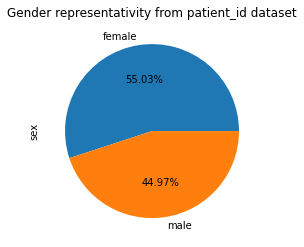

In [6]:
Patient_df.sex.value_counts().plot.pie(autopct="%0.2f%%")
plt.title("Gender representativity from patient_id dataset")

Challenge 2 - Although there are more females than males, the proportion by age group in each gender is not proportionately different, but quite different in each age group for eg dramatically more 10 year olds in male than female

In [7]:
data = Patient_df[["age","sex"]].dropna()
data = data.groupby(by=["age","sex"]).size().reset_index().rename(columns={0:"count"})
fig = go.Figure(data=[
    go.Bar(name='Female', x=data.age.unique(), y=data[data.sex=="female"]["count"], marker_color='pink'),
    go.Bar(name='Male', x=data.age.unique(), y=data[data.sex=="male"]["count"], marker_color='darkblue')
])
fig.update_layout(title_text='Age / Gender distribution of confirmed cases')
fig.show()

Gender distribution is much more evenly proportionate in terms of proportionate by provinces, except for 1 or 2 provinces

In [8]:
data = Patient_df[["province","sex"]].dropna()
data = data.groupby(by=["province","sex"]).size().reset_index().rename(columns={0:"count"})
fig = go.Figure(data=[
    go.Bar(name='Female', x=data.province.unique(), y=data[data.sex=="female"]["count"], marker_color='pink'),
    go.Bar(name='Male', x=data.province.unique(), y=data[data.sex=="male"]["count"], marker_color='darkblue')
])
fig.update_layout(title_text='province / Gender distribution of confirmed cases')
fig.show()

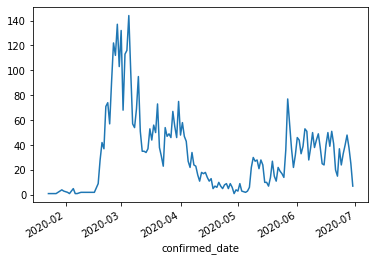

In [9]:
Patient_df.groupby(by=["confirmed_date"]).size().plot()

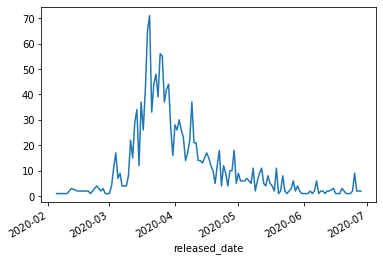

In [10]:
Patient_df.groupby(by=["released_date"]).size().plot()

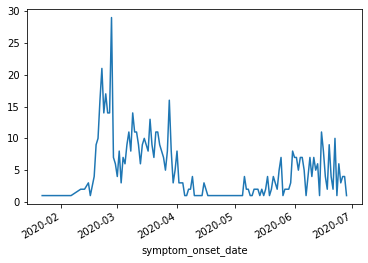

In [11]:
Patient_df.groupby(by=["symptom_onset_date"]).size().plot()

Most patients are infected by contact with patients

Text(0.5, 1.0, 'infection case with the Patient count')

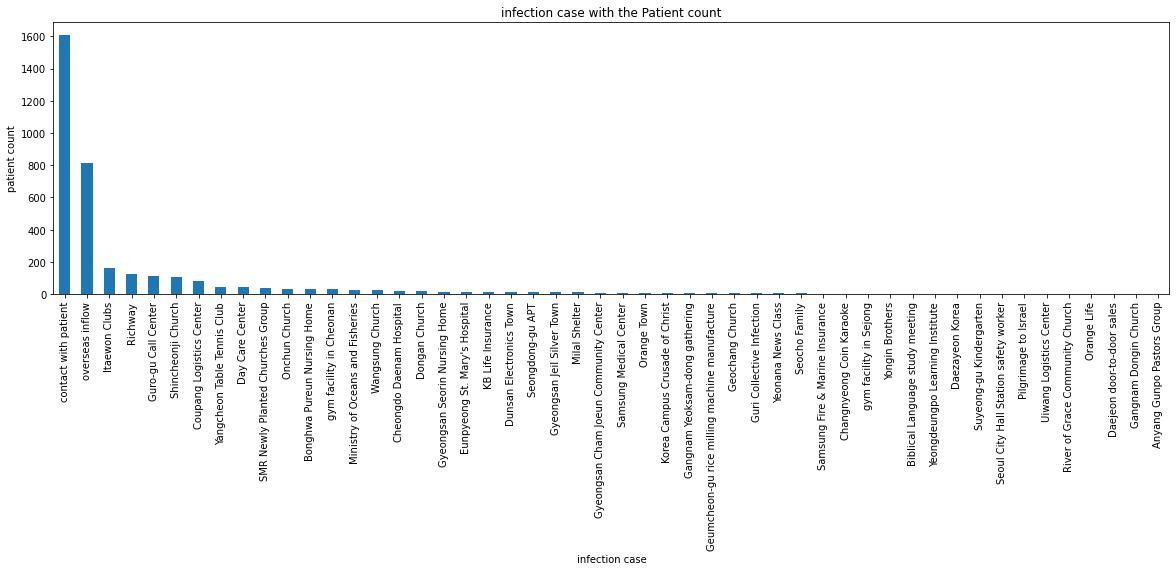

In [12]:
plt.figure(figsize=(20,5))
Patient_df.infection_case.value_counts().plot.bar()
plt.xlabel("infection case")
plt.ylabel("patient count")
plt.title("infection case with the Patient count")

Visual breakdown of age group and status - most 20 year olds contracted with covid, are also released and isolated. Most deaths occur for mature residents from 50s onwards

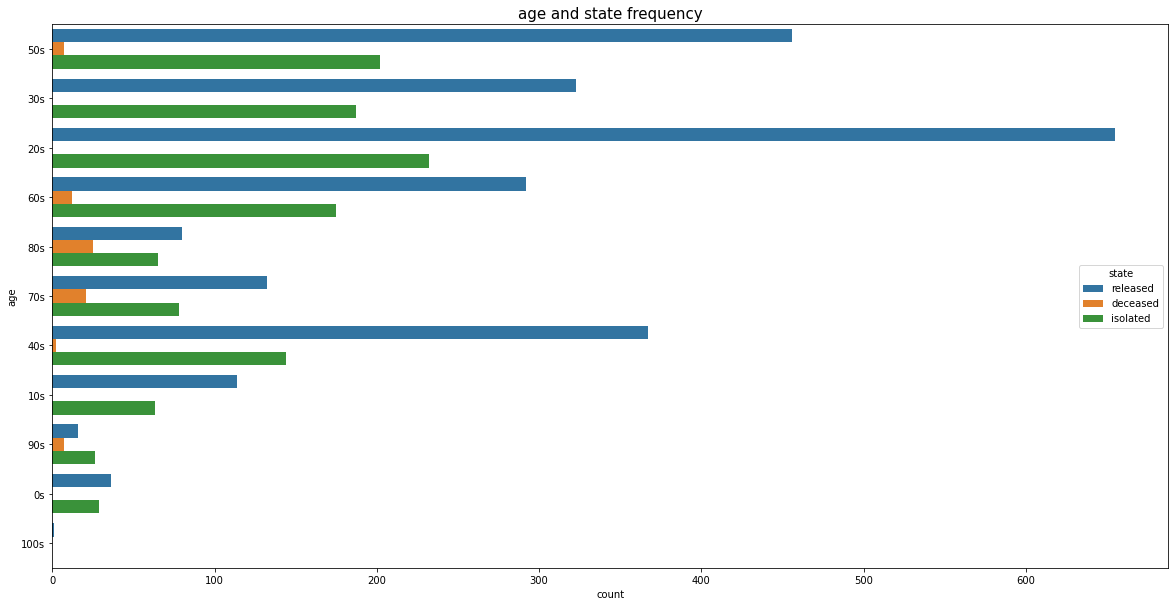

In [13]:
plt.figure(figsize=(20,10))
plt.title('age and state frequency',fontsize = 15)
sns.countplot(y='age', hue='state', data = Patient_df)

Combining Case_id dataset with patientinfo dataaset

In [14]:
Patient_df

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,deceased_days,released_days
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaT,released,NaN,13.0
1,1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,NaN,31.0,NaT,2020-01-30,2020-03-02,NaT,released,NaN,32.0
2,1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,2002000001,17.0,NaT,2020-01-30,2020-02-19,NaT,released,NaN,20.0
3,1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaT,released,NaN,16.0
4,1000000005,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,1000000002,2.0,NaT,2020-01-31,2020-02-24,NaT,released,NaN,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5156,7000000011,male,30s,Korea,Jeju-do,Jeju-do,contact with patient,7000000009,5.0,NaT,2020-04-03,2020-05-19,NaT,released,NaN,46.0
5157,7000000012,female,20s,Korea,Jeju-do,Jeju-do,overseas inflow,NaN,9.0,NaT,2020-04-03,2020-05-05,NaT,released,NaN,32.0
5159,7000000014,female,30s,Korea,Jeju-do,Jeju-do,Itaewon Clubs,NaN,140.0,NaT,2020-05-09,2020-06-12,NaT,released,NaN,34.0
5160,7000000015,female,30s,Korea,Jeju-do,Jeju-do,overseas inflow,NaN,25.0,NaT,2020-05-30,2020-06-13,NaT,released,NaN,14.0


Is there a correlation between age and the number of contacted persons

Pearsons correlation: 0.174


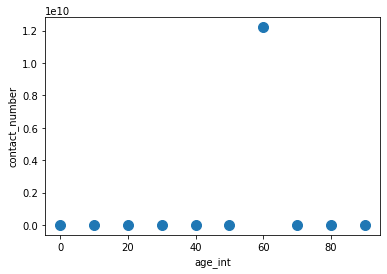

In [34]:
from scipy.stats import pearsonr
Patient_corr = Patient_df[['age','contact_number']].dropna()
Patient_corr['age_int'] = Patient_corr.age.str.replace("s","").astype(int)
Patient_corr_group = pd.DataFrame(Patient_corr.groupby('age_int')['contact_number'].sum().reset_index())


# calculate Pearson's correlation
corr, _ = pearsonr(Patient_corr_group.age_int, Patient_corr_group.contact_number)
print('Pearsons correlation: %.3f' % corr)
Patient_corr_group.plot.scatter(x = 'age_int', y = 'contact_number', s = 100)

In [45]:
#Patient_df.age.state()
Patient_df.groupby(['age','state'])['patient_id'].count()

age   state   
0s    isolated     29
      released     36
100s  released      1
10s   isolated     63
      released    114
20s   isolated    232
      released    655
30s   isolated    187
      released    323
40s   deceased      2
      isolated    144
      released    367
50s   deceased      7
      isolated    202
      released    456
60s   deceased     12
      isolated    175
      released    292
70s   deceased     21
      isolated     78
      released    132
80s   deceased     25
      isolated     65
      released     80
90s   deceased      7
      isolated     26
      released     16
Name: patient_id, dtype: int64